In [ ]:
%matplotlib widget
# This line can be deleted but it's just to allow nicer plots

import os
from amftrack.util.sys import (
    update_plate_info,
    get_current_folders,
)

from amftrack.pipeline.functions.image_processing.experiment_util import (
    plot_edge_color_value,
)

from amftrack.pipeline.functions.image_processing.experiment_class_surf import (
    Experiment,
)

import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
import networkx as nx
import numpy as np
from scipy.optimize import bisect
from scipy.stats import linregress
import seaborn as sns
import random

In [2]:
# Declare directory and get all folders containing Prince data
directory_targ = "/mnt/sun-temp/TEMP/amin_temp/"
update_plate_info(directory_targ, local=True)
all_folders = get_current_folders(directory_targ, local=True)

analysed:   0%|          | 0/974 [00:00<?, ?it/s]

In [3]:
# Check the available plates from those folders
print(all_folders["unique_id"].unique())

['447_20230821' '482_20230908' '483_20231005' '440_20230723'
 '441_20230807']


In [4]:
# Choose the plate you want using an id from the above list
folders = all_folders.loc[all_folders["unique_id"] == "482_20230908"]
folders = folders.sort_values(by="datetime")
# Select the timesteps you're interested in
folders = folders.iloc[52:53]
folders = folders[folders.apply(lambda row: os.path.exists(os.path.join(row['total_path'], 'Analysis')), axis=1)]

def has_graph_file(folder_path):
    analysis_path = os.path.join(folder_path, 'Analysis')
    return os.path.exists(os.path.join(analysis_path, 'nx_graph_pruned_labeled.p'))

# Filter out folders missing the nx_graph_pruned_labeled.p file
folders = folders[folders['total_path'].apply(has_graph_file)]

# Print the folder table. IMPORTANT: this allows you to see if all your folders exist and if you have selected the right amount (loading too many folders on an experiment will crash the kernel)
folders

,total_path,Plate,PrincePos,root,strain,medium,fungalC,split,Pbait,CrossDate,...,/Analysis/transform_corrupt.mat,/Analysis/skeleton_realigned_compressed.mat,/Analysis/nx_graph_pruned.p,/Analysis/nx_graph_pruned_width.p,/Analysis/nx_graph_pruned_labeled.p,/Analysis/nx_graph_pruned_labeled2.p,date,folder,unique_id,datetime
786,/mnt/sun-temp/TEMP/amin_temp/20230912_2242_Pla...,482,15,'Carrot','C2','001P100N100C','100P100N','Y','-',20230908,...,False,True,True,True,True,True,"12.09.2023, 22:42:",20230912_2242_Plate15,482_20230908,2023-09-12 22:42:00


In [5]:
# Create and load an experiment object
exp = Experiment(directory_targ)
exp.load(folders)
exp.dates.sort()
for t in range(len(folders)):
    exp.load_tile_information(t)

2023-09-12 22:42:00


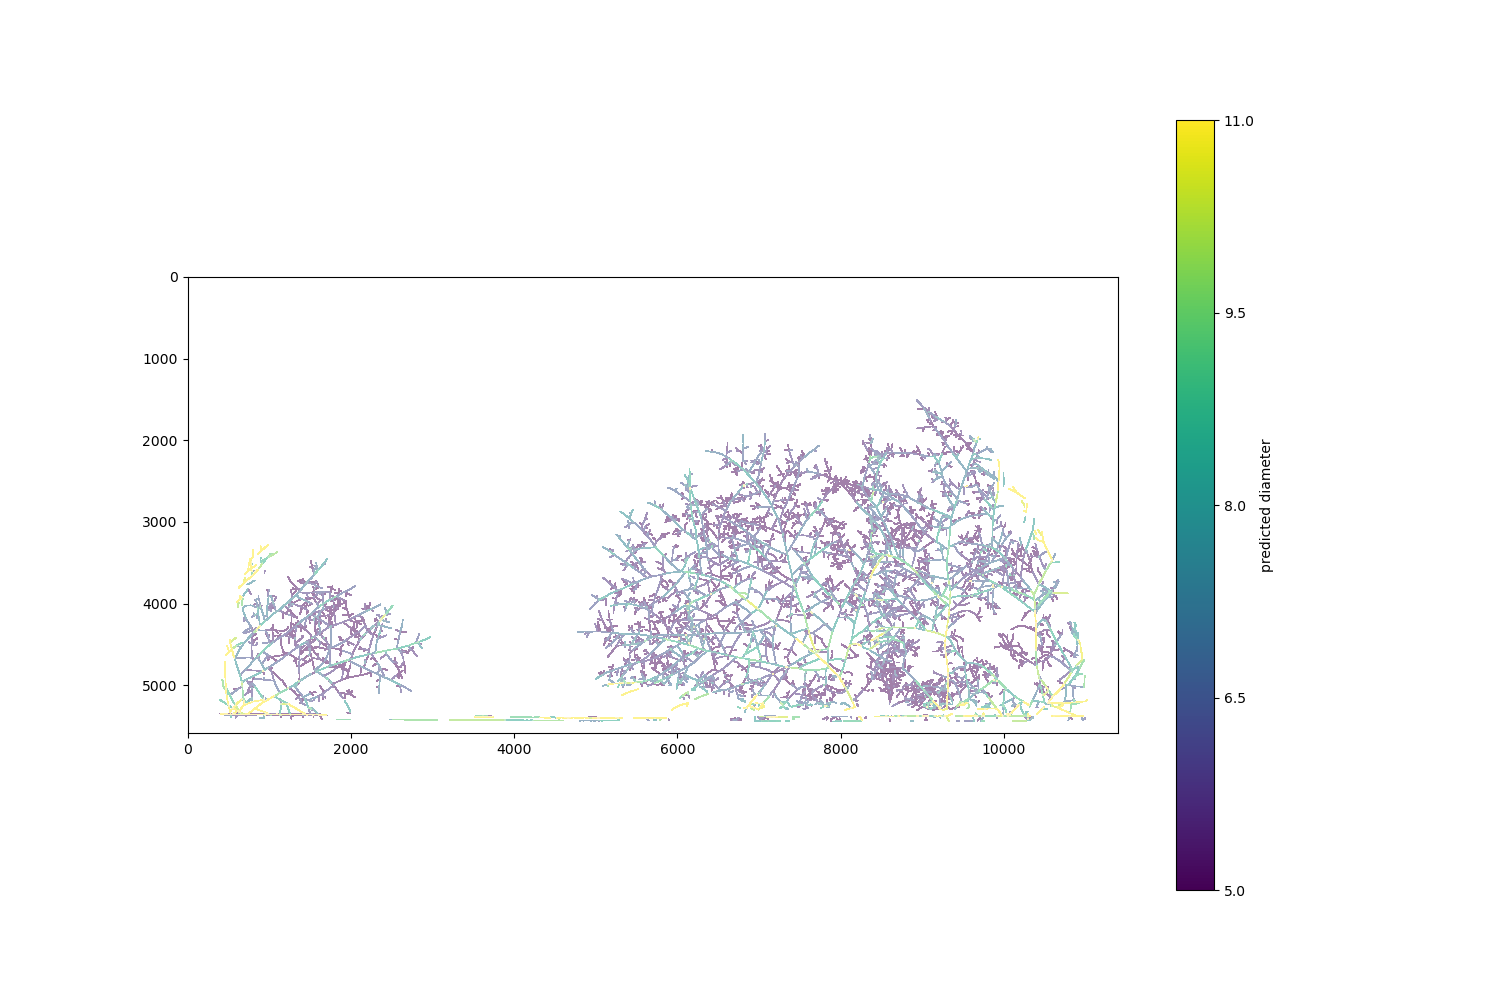

(<Figure size 1500x1000 with 2 Axes>, <AxesSubplot:>)

In [17]:
# Optional: print the network with diameters of a chosen timestep of your experiment object for verification of the network
plt.close('all')
t = 0
vmax = 11
vmin = 5
plot_edge_color_value(
    exp,
    t,
    lambda edge: edge.width(t),
    cmap=cm.viridis,
    v_min=vmin,
    v_max=vmax,
    plot_cmap=True,
    show_background=False,
    dilation=20,
    figsize=(15, 10),
    label_colorbar="predicted diameter",
)

# Extracting the radii from intersections across a chosen network

In [4]:
# Function to get an ordered triple of the widths of the neighboring edges of a given node
def get_triple(node, G):
    a,b,c = [neighbor for neighbor in G.neighbors(node)]
    a = G[node][a]['width']
    b = G[node][b]['width']
    c = G[node][c]['width']
    a,b,c = sorted([a,b,c], reverse=True)
    # Filter for absurd values
    if a==0 or c==0 or b==0:return []
    # Divide by 2 to have radius instead of diameter
    return [a/2, b/2, c/2]

G = exp.nx_graph[0]

# Creating a list of ordered triples of widths from each intersection with three edges
triples = [get_triple(label,G) for label in G.nodes() if G.degree(label) == 3]
# Remove the nans
triples = [value for value in triples if len(value)==3]

NameError: name 'exp' is not defined

# Computing the Murray exponent from a data set

In [5]:
# Bissection function to find the Murray exponent of each triple in a list
def solve_equation(triples, max_iterations=100, tolerance=1e-6):
    solutions = []
    for triple in triples:
        a, b, c = triple
        # Define the equation
        def equation(x):
            return a ** x - (b ** x + c ** x)

        # Find the interval where the function crosses the x-axis
        x = np.linspace(-1, 20, num=1000)
        y = equation(x)
        sign_changes = np.where(np.diff(np.sign(y)))[0]
        if len(sign_changes) == 0:
            continue  # Skip this solution if no sign changes are found
            
        for i in sign_changes:
            # Bisect the interval with a sign change to find the root
            try:
                root = bisect(equation, x[i], x[i+1])
                if root >= 1:
                    solutions.append([root, a, b, c])
            except ValueError:
                # Handle cases where no root is found within the interval
                pass # Both here and if there are no sign changes, you can store the values if you want or count them
    return solutions

# Creating a complete dataset of quadruples (exponent, r0, r1, r2)
murray_data = solve_equation(triples)

# Now you have a dataset from any plate in Prince data that you can already use for analysis

# Generating datasets from experimental data to match either the null hypothesis or Murray's Law

In [6]:
# First we bucket the dataset. This is helpful for generating data as we get rid of outliers locally, but can also be used for analysis too

def bucketing(quadruples):
    # Create a DataFrame from the input list
    df = pd.DataFrame(quadruples, columns=['exp', 'a', 'b', 'c'])
    
    # Choose the parameters you want to use to sort the data
    df['d1'] = df['a'] - df['b']
    df['d2'] = df['a']

    # Choose how many buckets you want
    NbBucketsPerAxis = 10
    NBNodes = len(df)
    NbStep = NBNodes / NbBucketsPerAxis / 2
    NbStep2 = NBNodes / NbBucketsPerAxis / NbBucketsPerAxis / 2
    
    Stats = np.zeros(((2 * NbBucketsPerAxis - 1) ** 2, 20))
    
    df = df.sort_values(by='d1').reset_index(drop=True)
    
    for i in range(0, 2 * NbBucketsPerAxis - 1):
        L1 = df.iloc[int(NbStep * i):int(NbStep * i + NbStep * 2 - 1)].sort_values(by='d2').reset_index(drop=True)
        for j in range(0, 2 * NbBucketsPerAxis - 1):
            L12 = L1.iloc[int(NbStep2 * j):int(NbStep2 * j + NbStep2 * 2 - 1)].reset_index(drop=True)
            
            Stats[i * (2 * NbBucketsPerAxis - 1) + j, 0] = L12['a'].quantile(0.10)
            Stats[i * (2 * NbBucketsPerAxis - 1) + j, 1] = L12['b'].quantile(0.10)
            Stats[i * (2 * NbBucketsPerAxis - 1) + j, 2] = L12['c'].quantile(0.10)
            Stats[i * (2 * NbBucketsPerAxis - 1) + j, 3] = L12['exp'].quantile(0.10)
            Stats[i * (2 * NbBucketsPerAxis - 1) + j, 4] = L12['a'].quantile(0.25)
            Stats[i * (2 * NbBucketsPerAxis - 1) + j, 5] = L12['b'].quantile(0.25)
            Stats[i * (2 * NbBucketsPerAxis - 1) + j, 6] = L12['c'].quantile(0.25)
            Stats[i * (2 * NbBucketsPerAxis - 1) + j, 7] = L12['exp'].quantile(0.25)
            Stats[i * (2 * NbBucketsPerAxis - 1) + j, 8] = L12['a'].quantile(0.50)
            Stats[i * (2 * NbBucketsPerAxis - 1) + j, 9] = L12['b'].quantile(0.50)
            Stats[i * (2 * NbBucketsPerAxis - 1) + j, 10] = L12['c'].quantile(0.50)
            Stats[i * (2 * NbBucketsPerAxis - 1) + j, 11] = L12['exp'].quantile(0.50)
            Stats[i * (2 * NbBucketsPerAxis - 1) + j, 12] = L12['a'].quantile(0.75)
            Stats[i * (2 * NbBucketsPerAxis - 1) + j, 13] = L12['b'].quantile(0.75)
            Stats[i * (2 * NbBucketsPerAxis - 1) + j, 14] = L12['c'].quantile(0.75)
            Stats[i * (2 * NbBucketsPerAxis - 1) + j, 15] = L12['exp'].quantile(0.75)
            Stats[i * (2 * NbBucketsPerAxis - 1) + j, 16] = L12['a'].quantile(0.90)
            Stats[i * (2 * NbBucketsPerAxis - 1) + j, 17] = L12['b'].quantile(0.90)
            Stats[i * (2 * NbBucketsPerAxis - 1) + j, 18] = L12['c'].quantile(0.90)
            Stats[i * (2 * NbBucketsPerAxis - 1) + j, 19] = L12['exp'].quantile(0.90)

    return Stats

def generate(quadruples, nb_points, WhiteNoise=0.1, MurrayExponent = 3):
    
    # Calculate bucket statistics
    stats = bucketing(quadruples)

    # Convert quadruples to DataFrame for easier processing
    df = pd.DataFrame(quadruples, columns=['exp', 'a', 'b', 'c'])
    
    # Calculate ln(ln(L2)) & its stats
    df['ln_ln_L2'] = np.log(np.log(df['b']))
    AverageL2 = df['ln_ln_L2'].mean() * 0.975
    STDevL2 = df['ln_ln_L2'].std()
        
    # Estimate relationship between L3 & ln(L2)
    for row in stats:
        row[9] = np.log((row[9]))
    Stats_array = np.array(stats)
    x = Stats_array[:, 9]
    y = Stats_array[:, 10]
    SlopeL3L2, interceptL3L2, r_value, p_value, std_err = linregress(x, y)
    
    # Generate points for our two generated datasets
    null_hypot = []
    murray = []
    
    for i in range(nb_points):
        L2 = np.exp(np.exp(np.random.normal(loc=AverageL2, scale=STDevL2)))
        L2 = L2 * np.exp(np.random.normal(loc=0, scale=WhiteNoise))
        L3 = SlopeL3L2 * np.log(L2) + interceptL3L2
        L3 = L3 * np.exp(np.random.normal(loc=0, scale=WhiteNoise))
        L1murray = ((L2 ** MurrayExponent) + (L3 ** MurrayExponent)) ** (1 / MurrayExponent)
        L1murray = L1murray * np.exp(np.random.normal(loc=0, scale=WhiteNoise))
        L1null = L2 * np.exp(np.random.normal(loc=0, scale=WhiteNoise))
            
        murray.append(sorted([L1murray,L2,L3], reverse=True))
        null_hypot.append(sorted([L1null,L2,L3], reverse=True))
    
    return murray, null_hypot

generated_murray, generated_null_hypot = generate(murray_data, 1000, 0.126)

# Complete the generated datasets by computing the exponents
final_murray = solve_equation(generated_murray)
final_null = solve_equation(generated_null_hypot)

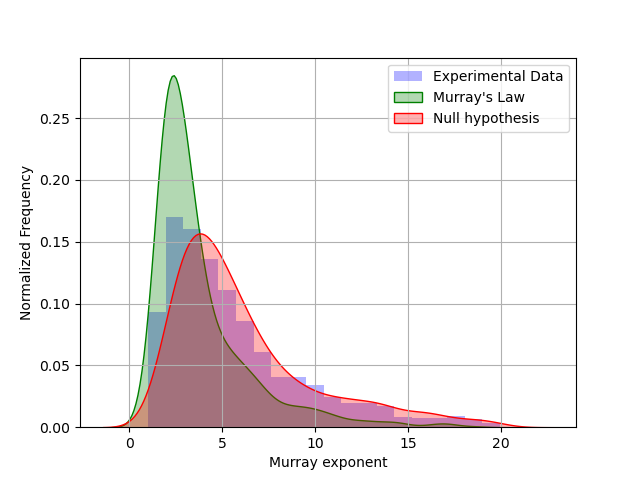

In [16]:
# Now you have three datasets that you can compare
# Let's plot the figures used in my report
plt.close('all')

exponent1 = [item[0] for item in murray_data]
exponent2 = [item[0] for item in final_murray]
exponent3 = [item[0] for item in final_null]

plt.hist(exponent1, bins = 20, color='blue', label='Experimental Data', density=True, alpha=0.3)
sns.kdeplot(exponent2, color='green', label="Murray's Law", fill=True, alpha=0.3)
sns.kdeplot(exponent3, color='red', label='Null hypothesis', fill=True, alpha=0.3)

# Add labels and title
plt.xlabel('Murray exponent')
plt.ylabel('Normalized Frequency')
#plt.xlim(0,15)

# Add grid, legend, and show plot
plt.grid(True)
plt.legend()
plt.show()

# Same thing but using manual measures from Morrison images
Since it was difficult to conclude from the above plot, we decide to do the same thing but with Morrison data, since the noise from manual measures is around 7% which is significantly smaller than the 12,6% from Prince data. For this, you need to download the csv containing the measures.

In [7]:
# The format of the measure csv is very raw: pairs of diameters, three consecutive pairs are an intersection

# Read the CSV file into a pandas DataFrame
df = pd.read_csv('murray_data.csv')

# Perform row pair averaging
df['index'] = df.index // 2
df = df.groupby('index').mean()

# Initialize arrays a, b, and c
triples = []

# Iterate over daughter_table_3 in chunks of three rows
for i in range(0, len(df), 3):
    # Sort the 'diameter' values within each chunk from highest to lowest
    triples.append(sorted(df['diameter'].iloc[i:i+3], reverse=True))

# Add the exponents
murray_data2 = solve_equation(triples)

In [8]:
# Generate new data with the matching level of noise
generated_murray, generated_null_hypot = generate(murray_data, 1000, 0.07)

# Complete the generated datasets by computing the exponents
final_murray = solve_equation(generated_murray)
final_null = solve_equation(generated_null_hypot)

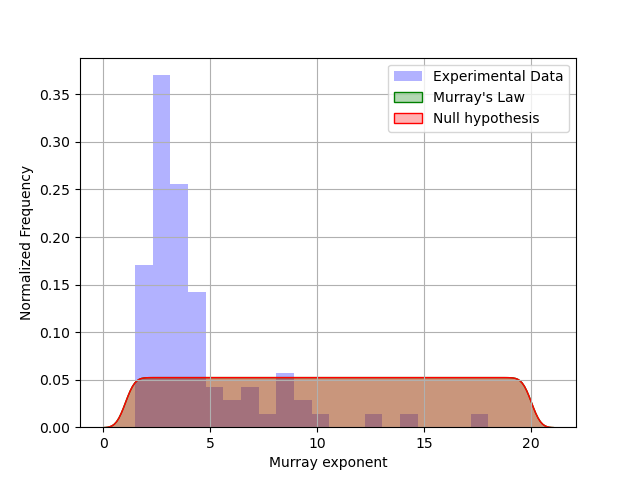

In [9]:
# Now you have three datasets that you can compare
# Let's plot the figures used in my report
plt.close('all')

exponent1 = [item[0] for item in murray_data2]
exponent2 = [item[0] for item in final_murray]
exponent3 = [item[0] for item in final_null]

plt.hist(exponent1, bins = 20, color='blue', label='Experimental Data', density=True, alpha=0.3)
sns.kdeplot(exponent2, color='green', label="Murray's Law", fill=True, alpha=0.3)
sns.kdeplot(exponent3, color='red', label='Null hypothesis', fill=True, alpha=0.3)

# Add labels and title
plt.xlabel('Murray exponent')
plt.ylabel('Normalized Frequency')
#plt.xlim(0,15)

# Add grid, legend, and show plot
plt.grid(True)
plt.legend()
plt.show()